#Tugas Crawling_berita_Kompas
*   Nama : Muhammad Adam Zaky Jiddyansah
*   NIM : 210411100234
*   Kelas : Penambangan dan Pencarian Web B



##Menginstall dan mengimport library yang dibutuhkan
Libraries yang Digunakan
*   BeautifulSoup (bs4): Library untuk melakukan web scraping dan ekstraksi data HTML.
*   Requests: Library untuk membuat permintaan HTTP ke situs web dan mendapatkan konten halaman.
*   Pandas (pd): Library untuk mengelola dan menyimpan data dalam format CSV.


In [40]:
from bs4 import BeautifulSoup as soup
import requests
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

In [41]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

##Web Scraping Berita Kompas dan Penyimpanan ke Google Drive
Kode ini menggunakan teknik web scraping untuk mengumpulkan judul dan isi berita dari 200 halaman indeks situs Kompas.com. Berikut adalah penjelasan komponen utama dari kode tersebut:

**Proses Web Scraping dan menyimpan data**
*   Iterasi sebanyak 200 halaman indeks(tergantung indeks pada website) di situs Kompas.com.
*   Untuk setiap halaman, melakukan permintaan HTTP dan mendapatkan konten HTML.
*   Menggunakan BeautifulSoup untuk mengekstrak daftar berita dari halaman tersebut.
*   Untuk setiap berita, mengakses halaman individu untuk mengambil judul dan isi berita.
*   Data judul dan isi berita ditambahkan ke dalam dictionary csv.
Penyimpanan Data
*   Setelah proses scraping selesai, data disimpan dalam file CSV dengan nama "Data_BeritaKompas.csv" terlebih dahulu di environment Colab.
*   File CSV tersebut disalin ke dalam Google Drive pada path "/content/drive/My Drive/Penambangan WEB/Data/".





In [42]:
from google.colab import drive
drive.mount('/content/drive')

csv = {"Judul": [], "Berita": []}

for i in range(1, 10):
    url = "https://indeks.kompas.com/?page={}".format(i)
    client = requests.get(url)
    page_html = client.content
    page_soup = soup(page_html, "html.parser")
    berita = page_soup.findAll("div", {"class": "latest--indeks mt2 clearfix"})

    for h in berita:
        r = requests.get(h.select_one('a.article__link')['href'])
        page = soup(r.content, "html.parser")
        halaman_isi = page.select_one("div", {"class": "col-bs10-10"})

        judul_berita = halaman_isi.select("h1", {"class": "read__title"})
        judul = judul_berita[0].text

        isi_berita = halaman_isi.findAll('p')
        isi = '\n'.join([p.get_text() for p in isi_berita])

        csv["Judul"].append(judul)
        csv["Berita"].append(isi)

        data = pd.DataFrame(csv)
        csv_path_drive = '/content/drive/My Drive/Penambangan WEB/Data/Data_BeritaKompas.csv'
        data.to_csv(csv_path_drive, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import dan Membaca Data CSV
Menggunakan Pandas untuk membaca file CSV yang telah disimpan sebelumnya. File CSV tersebut berisi data judul dan isi berita dari Kompas.com yang telah di-web scrape sebelumnya, lalu menampilkan data yang telah dibaca dari file CSV dalam bentuk DataFrame untuk dapat dianalisis lebih lanjut.

In [43]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/Penambangan WEB/Data/Data_BeritaKompas.csv"
df = pd.read_csv(file_path)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Judul,Berita
0,"Berkaca dari Kasus di UNY, Bagaimana Sebaiknya...","Berkaca dari Kasus di UNY, Bagaimana Sebaiknya..."
1,"Hadapi Tekanan Inflasi, Bangka Belitung Giatka...","Hadapi Tekanan Inflasi, Bangka Belitung Giatka..."
2,"Tak Ada Kantong Parkir di GBK, Penonton Coldpl...","Tak Ada Kantong Parkir di GBK, Penonton Coldpl..."
3,Adu Spesifikasi Oppo Find N3 Vs Samsung Galaxy...,Adu Spesifikasi Oppo Find N3 Vs Samsung Galaxy...
4,"VIDEO: Hoaks Ahok Dilantik Jadi Ketua KPK, Sim...","VIDEO: Hoaks Ahok Dilantik Jadi Ketua KPK, Sim..."
5,"Nanti Malam Konser Coldplay, Lalin di Sekitar ...","Nanti Malam Konser Coldplay, Lalin di Sekitar ..."
6,154 Hektare Hutan Lindung Kaki Gunung Slamet D...,154 Hektare Hutan Lindung Kaki Gunung Slamet D...
7,"Dapat Nomor Urut 2, Gibran: Semua Nomor Bagus Kok","Dapat Nomor Urut 2, Gibran: Semua Nomor Bagus ..."
8,"Sinopsis Women From Rote Island, Kisah Pilu Ko...","Sinopsis Women From Rote Island, Kisah Pilu Ko..."


##Mengambil salah satu berita untuk menjadi sampel data yang akan dianalisis

In [44]:
Berita = df['Berita'].iloc[1]
Berita

'Hadapi Tekanan Inflasi, Bangka Belitung Giatkan Tanam Cabai Merah\nTim Redaksi\nBANGKA, KOMPAS.com -\xa0Sebanyak 20 ton cabai merah berhasil dipanen dari dua kelompok tani di Kepulauan Bangka Belitung selama Oktober-November 2023.\nPenanaman cabai tersebut digiatkan untuk memenuhi kebutuhan pangan lokal sekaligus mencegah inflasi.\n"Hasil panen cabai merah tersebut diharapkan dapat meningkatkan jumlah pasokan cabai merah lokal sehingga stabilitas harga cabai merah di Bangka Belitung semakin terjaga," kata Plt Kepala Perwakilan Bank Indonesia (BI) Kepulauan Bangka Belitung Agus Taufik pada awak media di Pangkalpinang, Rabu (15/11/2023).\nAgus menuturkan, pada pekan kedua November 2023 rata-rata harga cabai merah di pasar tradisional Pangkalpinang sebesar Rp75.000 per kilogram Sedangkan di Tanjungpandan sebesar Rp 93.000 per kilogram.\n"BI Babel bersinergi dengan Pemerintah Daerah akan terus mendorong produktivitas pangan lokal untuk mendukung program kemandirian pangan, antara lain kom

##Pra-pemrosesan Teks / Preprocessing

Mengambil teks sebagai input dan melakukan beberapa langkah pra-pemrosesan pada teks dalam bahasa Indonesia. Langkah-langkah tersebut mencakup penghapusan angka, pembersihan karakter khusus, konversi teks ke huruf kecil, penghapusan kata-kata umum (stopwords), dan penggabungan kata-kata yang telah melalui proses sebelumnya. Tujuannya adalah membersihkan dan mempersiapkan teks agar dapat digunakan lebih lanjut dalam analisis atau pemrosesan lanjutan.


In [45]:
def preprocessing(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s.]', '', text)
    text = text.lower()

    stop_words = set(stopwords.words('indonesian'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]

    preprocessing_text = ' '.join(filtered_words)

    return preprocessing_text

kalimat_preprocessing = preprocessing(Berita)

kalimat = nltk.sent_tokenize(Berita)
kalimat_preprocessing = nltk.sent_tokenize(kalimat_preprocessing)

##Metode pengukuran TF-IDF
Mengonversi teks yang sudah melewati tahap pra-pemrosesan menjadi representasi matriks numerik menggunakan skema TF-IDF. Matriks ini mencerminkan bobot TF-IDF dari setiap kata dalam setiap kalimat. Setelah transformasi, DataFrame pandas dibuat untuk menyajikan matriks tersebut dengan kata-kata sebagai kolom dan setiap baris mewakili satu kalimat, menunjukkan bobot TF-IDF dari kata-kata tersebut dalam kalimat tersebut.

In [46]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_preprocessing = tfidf_vectorizer.fit_transform(kalimat_preprocessing)

terms = tfidf_vectorizer.get_feature_names_out()
tfidf_preprocessing = pd.DataFrame(data=tfidf_matrix_preprocessing.toarray(), columns=terms)

tfidf_preprocessing

,acara,agus,air,akselerasi,alternatif,artikel,awak,ayam,babel,baca,...,tercatat,terjaga,tim,timur,ton,total,tradisional,transaksi,tujuan,uang
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.218156,0.000000,0.146643,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.139857,0.000000,0.000000,0.000000,0.000000,0.192483,0.000000,0.000000,0.000000,...,0.000000,0.192483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.257268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.354074,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.154900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.213186,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199353,...,0.000000,0.000000,0.000000,0.199353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.197297,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.251759,0.192522,0.251759,0.000000,0.000000,0.000000,0.000000


##Perhitungan Kemiripan Kosinus
Menghitung kemiripan kosinus antara semua pasangan kalimat menggunakan matriks TF-IDF yang telah dihasilkan sebelumnya. Kemudian, hasil kemiripan kosinus tersebut disimpan dalam DataFrame untuk kemudahan analisis.

**Rumus Perhitungan Kemiripan Kosinus:**
*   Untuk dua vektor A dan B, kemiripan kosinus dihitung dengan rumus $$ \text{Similarity}(A, B) = \frac{{A \cdot B}}{{\|A\| \cdot \|B\|}} $$

*   Di sini, ⋅ adalah operasi perkalian dot (dot product), dan ∥∥ adalah norma Euclidean. Dalam konteks ini, vektor A dan B adalah vektor representasi TF-IDF dari dua kalimat. Hasilnya adalah skalar yang menunjukkan seberapa mirip dua kalimat tersebut, dengan nilai 1 menunjukkan kemiripan sempurna.


In [49]:
cosine_sim_preprocessing = cosine_similarity(tfidf_matrix_preprocessing, tfidf_matrix_preprocessing)
cosine_sim_df = pd.DataFrame(cosine_sim_preprocessing, columns=range(len(kalimat_preprocessing)), index=range(len(kalimat_preprocessing)))
cosine_sim_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,0.093965,0.338517,0.090408,0.000000,0.000000,0.108868,0.235576,0.179200,0.150364,0.000000,0.182399,0.000000,0.039138,0.129261,0.060669,0.089078,0.062952,0.000000,0.201183
1,0.093965,1.000000,0.100906,0.033110,0.000000,0.000000,0.156587,0.055655,0.027447,0.026782,0.000000,0.138906,0.000000,0.060898,0.045904,0.053862,0.270477,0.000000,0.000000,0.000000
2,0.338517,0.100906,1.000000,0.260952,0.000000,0.000000,0.223270,0.119808,0.169020,0.189840,0.000000,0.166614,0.055739,0.051798,0.091239,0.080294,0.000000,0.000000,0.050213,0.000000
3,0.090408,0.033110,0.260952,1.000000,0.171480,0.000000,0.128198,0.019385,0.060818,0.137703,0.000000,0.040616,0.046327,0.031761,0.000000,0.049234,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.171480,1.000000,0.550965,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.550965,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.108868,0.156587,0.223270,0.128198,0.000000,0.000000,1.000000,0.086785,0.073237,0.071464,0.000000,0.156819,0.074845,0.190495,0.050527,0.059287,0.000000,0.000000,0.000000,0.000000
7,0.235576,0.055655,0.119808,0.019385,0.000000,0.000000,0.086785,1.000000,0.175116,0.300606,0.000000,0.083983,0.037627,0.062514,0.133585,0.031535,0.000000,0.000000,0.000000,0.000000
8,0.179200,0.027447,0.169020,0.060818,0.000000,0.000000,0.073237,0.175116,1.000000,0.422965,0.258002,0.025007,0.060861,0.026329,0.034782,0.040813,0.119848,0.084697,0.000000,0.000000
9,0.150364,0.026782,0.189840,0.137703,0.000000,0.000000,0.071464,0.300606,0.422965,1.000000,0.000000,0.024402,0.043828,0.025691,0.033941,0.167294,0.116948,0.082647,0.000000,0.000000


##Visualisasi Hubungan Antar Kalimat Menggunakan Graf (Graph) berdasarkan Cosine Similarity
Membuat graf yang merepresentasikan hubungan antara kalimat-kalimat berdasarkan nilai cosine similarity. Setiap kalimat direpresentasikan sebagai node, dan garis yang menghubungkan dua node menunjukkan tingkat kemiripan antara kalimat tersebut. Semakin panjang dan tebal garis, semakin tinggi tingkat kemiripan antara dua kalimat. Graf ini membantu memvisualisasikan struktur hubungan antar kalimat dalam teks.

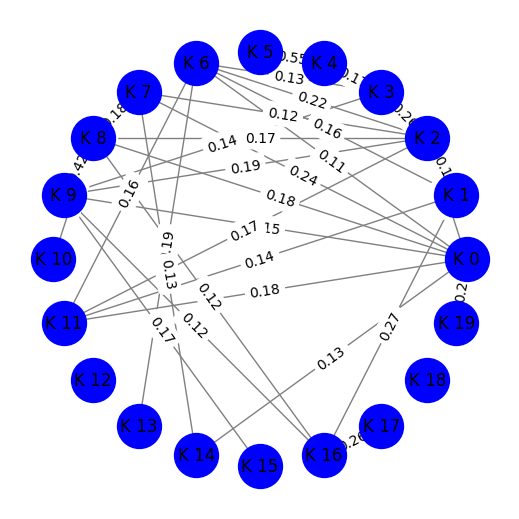

In [50]:
G_preprocessing = nx.Graph()

for i in range(len(cosine_sim_preprocessing)):
    G_preprocessing.add_node(i)

for i in range(len(cosine_sim_preprocessing)):
    for j in range(len(cosine_sim_preprocessing)):
        similarity = cosine_sim_preprocessing[i][j]
        if similarity > 0.1 and i != j:
            G_preprocessing.add_edge(i, j, weight=similarity)

pos = nx.circular_layout(G_preprocessing)

labels = {i: f'K {i}' for i in G_preprocessing.nodes()}

edge_labels = {(i, j): round(data['weight'], 2) for i, j, data in G_preprocessing.edges(data=True)}

node_size = 1000

node_color = 'blue'
edge_color = 'gray'

plt.figure(figsize=(5, 5))
nx.draw(G_preprocessing, pos, with_labels=True, labels=labels, node_size=node_size, node_color=node_color, edge_color=edge_color)
nx.draw_networkx_edge_labels(G_preprocessing, pos, edge_labels=edge_labels)
plt.show()


##Closeness

Menghitung dan menganalisis Closeness Centrality pada graf G_preprocessing.
Rumus Perhitungan Closeness Centrality:

